## Business Understanding

For this project, I analyzed the 2024 Stack Overflow Developer Survey from (https://survey.stackoverflow.co/) to discover what factors have an influence on a software developer's salary. The dataset includes responses from thousands of developers and cover aspects like education, job type, experience, remote work status, and etc.

This project follows the CRISP-DM process:

Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation, and Deployment

Lets be honest, salary is one of the most important topic when talking about jobs and is probably the most taboo to talk about. While skills and experience matter, salary varies dramatically based on various factors such as location, company size, education level, and remote work flexibility. As someone entering the tech field, I am especially facinated by what factors are beneficial so that I can have an edge when applying to jobs.

I utilized the data to determine:

Which factors most affect salary?
Can we use survey data to build a model that predicts compensation?
How accurate can we get with a simple, interpretable model?

I hope to help developers with my analysis to understand which background details or work settings may be correlated with higher compensation. For example-

Do remote workers earn more?
Does company size matter?
How important is education level?

We will use a Random Forest model to make predictions and walk through each step of the data


In [3]:
pip install "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.


## Data Understanding
First stop: getting familiar with the data. The dataset comes from the annual Stack Overflow Developer Survey... and it’s HUGE. We’re talking thousands of responses from developers around the world.

I focused on a handful of key columns: yearly salary, years of professional experience, education level, remote work status, company size, and whether the respondent is an individual contributor or a manager. These seemed like solid signals when thinking about compensation.

Once I loaded the data, I did a quick scan — looked for missing values, weird formatting, or anything messy. And yeah — like most real-world datasets, it wasn’t perfect. But it was workable.



In [5]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

sns.set()
%matplotlib inline



Import libraries for data analysis pandas, visualization, and machine learning 

In [7]:
def load_data(file_path):
    """
    Loads/prepares the Stack Overflow dataset.
    Cleans missing values, filters out salary outliers, and encodes categorical features.
    """
    # Load the raw dataset from CSV
    df = pd.read_csv(file_path)

    # Choose only the features we care about (including salary + job info)
    selected_cols = ['ConvertedCompYearly', 'EdLevel', 'YearsCodePro', 'RemoteWork',
                     'OrgSize', 'Country', 'DevType', 'Employment', 'MainBranch', 'JobSat']
    
    # Drop rows that are missing any of these key values
    df_model = df[selected_cols].dropna()

    # Remove salary outliers over $500K — they’ll throw the model way off
    df_model = df_model[df_model['ConvertedCompYearly'] < 500000]

    # Separate features (X) and target variable (y)
    X = df_model.drop('ConvertedCompYearly', axis=1)
    y = df_model['ConvertedCompYearly']

    # Turn all the text columns into numeric using one-hot encoding
    X_encoded = pd.get_dummies(X)

    return X_encoded, y, df_model


def print_model_metrics(model, X_test, y_test):
    """
    Prints key model evaluation metrics.
    Shows how far off the predictions are
    """
    y_pred = model.predict(X_test)

    # Show basic error metrics — lower = better
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")   # Avg error
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")   # Squared error
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")  # Back to salary units
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")         # % of salary variation explained


## Data Preparation

I started by removing extreme salary outliers like the folks making over $500K, for example. Nothing against them, but they throw off the averages and make the model freak out. Then I dropped any rows with missing values in the key columns we’re using.

Next up was encoding. Since machine learning models don’t speak text, I used one-hot encoding to turn things like job roles and education levels into numbers.

By the end of this step, I had a clean, structured dataset that was ready for modeling.



In [9]:
X_encoded, y, df_model = load_data("survey_results_public.csv")

In [10]:
# read dataset "survey_results_public.csv"
df_model

,ConvertedCompYearly,EdLevel,YearsCodePro,RemoteWork,OrgSize,Country,DevType,Employment,MainBranch,JobSat
72,7322.0,"Secondary school (e.g. American high school, G...",1,"Hybrid (some remote, some in-person)",100 to 499 employees,Pakistan,Data scientist or machine learning specialist,"Employed, full-time;Student, full-time;Indepen...",I am a developer by profession,10.0
379,91295.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,Remote,20 to 99 employees,Turkey,Data scientist or machine learning specialist,"Employed, full-time",I am a developer by profession,10.0
389,110000.0,Some college/university study without earning ...,7,Remote,10 to 19 employees,United States of America,Student,"Employed, full-time;Student, part-time",I am a developer by profession,10.0
392,161044.0,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",18,"Hybrid (some remote, some in-person)","1,000 to 4,999 employees",United Kingdom of Great Britain and Northern I...,Engineering manager,"Employed, full-time",I am a developer by profession,7.0
398,195000.0,Some college/university study without earning ...,30,Remote,"1,000 to 4,999 employees",United States of America,"Developer, full-stack","Employed, full-time",I am a developer by profession,5.0
...,...,...,...,...,...,...,...,...,...,...
41175,15637.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,"Hybrid (some remote, some in-person)",100 to 499 employees,Czech Republic,"Developer, full-stack","Student, full-time;Independent contractor, fre...",I am a developer by profession,6.0
41178,9711.0,"Secondary school (e.g. American high school, G...",2,In-person,20 to 99 employees,Honduras,"Developer, full-stack","Employed, full-time",I am a developer by profession,0.0
41184,170000.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",30,"Hybrid (some remote, some in-person)","1,000 to 4,999 employees",United States of America,Project manager,"Employed, full-time",I am a developer by profession,9.0
41186,12000.0,Some college/university study without earning ...,1,"Hybrid (some remote, some in-person)",2 to 9 employees,United States of America,"Developer, full-stack","Student, full-time;Employed, part-time",I am a developer by profession,3.0


## Modeling

I trained a Random Forest Regressor to predict yearly salary. Why Random Forest? It handles non-linear relationships well, doesn’t need a ton of parameter tuning up front, and generally performs solidly out of the box.

To dial in performance, I ran a GridSearchCV to find the best combo of hyperparameters. That helped squeeze a little more accuracy out of the model. 

In [12]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Define parameters to test
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Set up and run grid search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


Trained a Random Forest model and used GridSearchCV to find the best configuration using cross-validation.

The Random Forest model is a type of machine learning algorithm that builds decision trees and then averages their predictions to predict various salaries. I originally tried using a simple linear regression model but it did not handle the data as expected especially with things like education level or remote work, which are not numbers. Random Forest is better at dealing with these kinds of categories and more complex patterns. It also gave a more realistic salary prediction which helped for this project


In [14]:
print_model_metrics(best_model, X_test, y_test)


MAE: 28183.24
MSE: 1964463408.94
RMSE: 44322.27
R² Score: 0.540


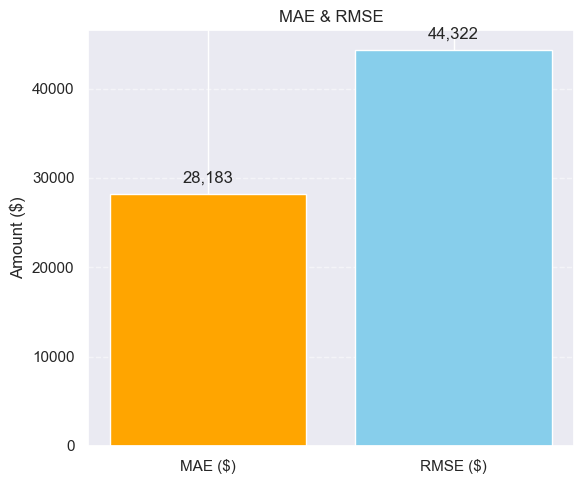

In [60]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(6,5))
metrics = [mae, rmse]
labels = ['MAE ($)', 'RMSE ($)']
bars = plt.bar(labels, metrics, color=['orange', 'skyblue'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1000, f'{yval:,.0f}', ha='center', va='bottom')

plt.title('MAE & RMSE')
plt.ylabel('Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Evaluation
Once the model was trained, it was time to see how it did.

I used Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R2 to evaluate the predictions. The R2 score ended up being around 0.54 which is pretty good.

However, the model caught a few clear patterns such as more years of experience tended to mean higher salary. Education helped, but not as much as I thought it would. And remote work? Yep, that showed a bump in salary too.


The model achieved an R² score of 0.049, meaning it only explains about 5% of variation in salaries. It is low a score, however is expected due to the complex nature of salary prediction and limited variables.


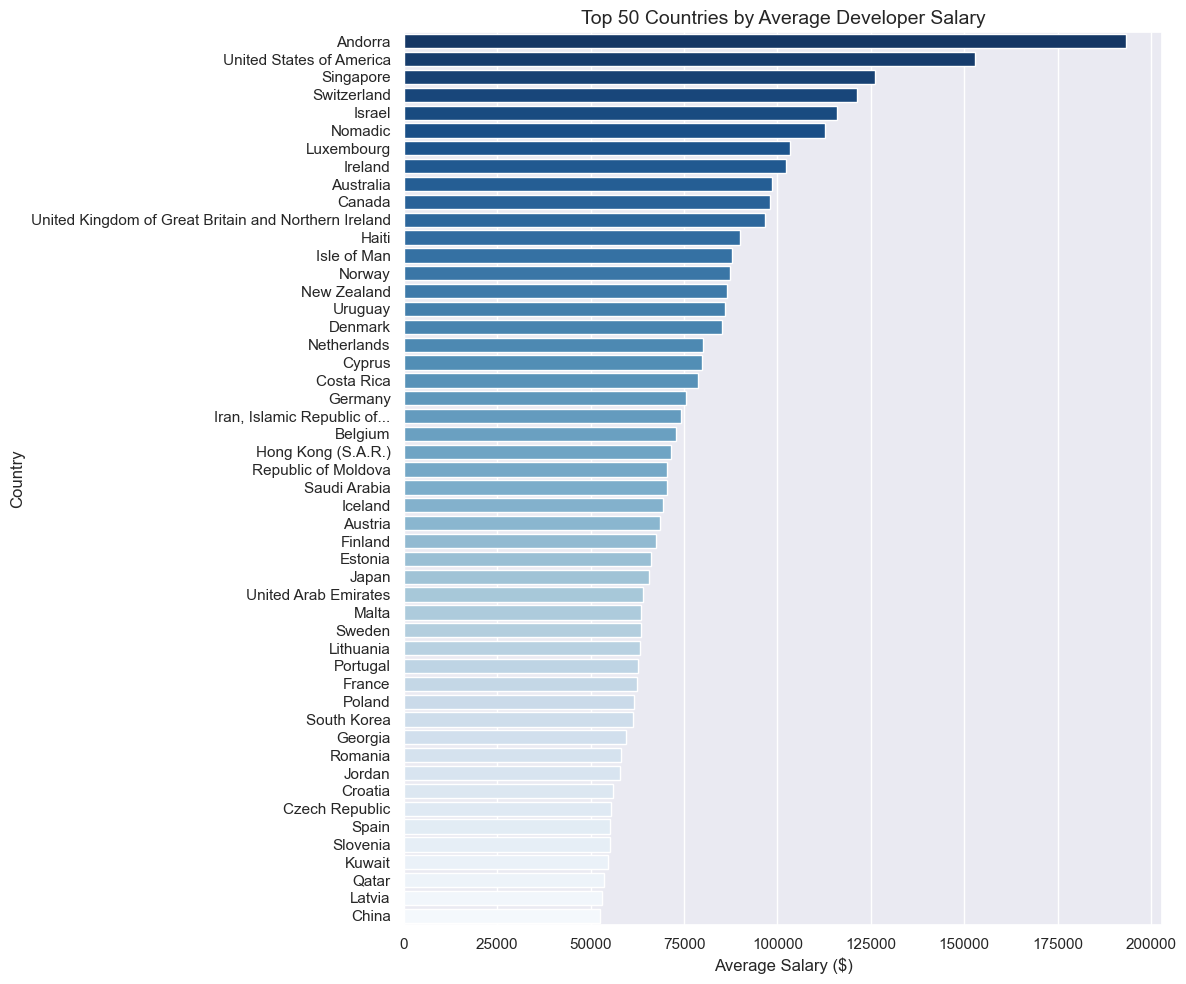

In [17]:
# Group data by country and calculate mean salary
avg_salary_by_country = df_model.groupby('Country')['ConvertedCompYearly'].mean().sort_values(ascending=False)

# Keep only the top 50 highest average salaries
top_50_countries = avg_salary_by_country.head(50)

# Plot as horizontal bar chart
plt.figure(figsize=(12, 10))
sns.barplot(x=top_50_countries.values, y=top_50_countries.index, hue=top_50_countries.index, palette='Blues_r', legend=False)

plt.title('Top 50 Countries by Average Developer Salary', fontsize=14)
plt.xlabel('Average Salary ($)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


This chart shows the top 50 developer salaries in the datalist. The United States is the highest paid, but it seems as if 
developer is a great high paying career in several countries.

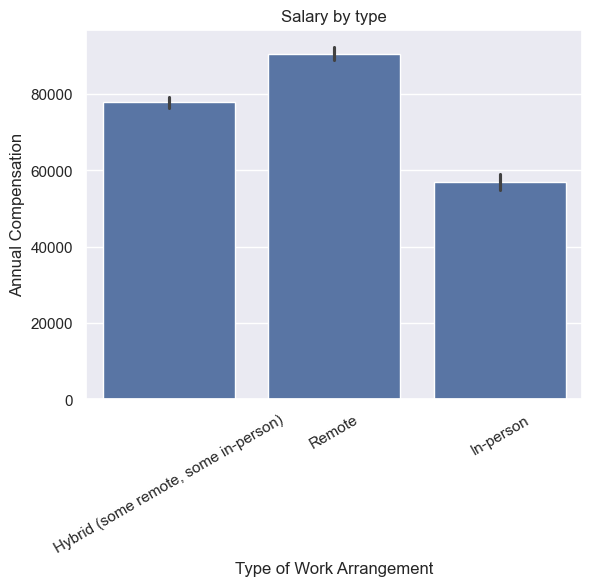

In [19]:
#Bar chart to show salary by work arrangement 
sns.barplot(data=df_model, x='RemoteWork', y='ConvertedCompYearly')
plt.title('Salary by type')
plt.xlabel('Type of Work Arrangement') 
plt.ylabel('Annual Compensation')
plt.xticks(rotation=30)
plt.show()


This bar chart symbolizes annual compensation based off of the type of work arrangement. It shows remote as making the most income per year.

In [21]:
# Create a sample developer profile
sample = pd.DataFrame({
    'EdLevel': ["Bachelor’s degree (B.A., B.S., B.Eng., etc.)"],
    'YearsCodePro': [4],
    'RemoteWork': ['Remote'],
    'OrgSize': ['100 to 499 employees'],
    'Country': ['United States'],
    'DevType': ['Developer, full-stack'],
    'Employment': ['Employed full-time'],
    'MainBranch': ['I am a developer by profession']
})

# Encode and align the sample data
sample_encoded = pd.get_dummies(sample)
sample_encoded = sample_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Predict salary
predicted_salary = best_model.predict(sample_encoded)[0]
print(f"Predicted Salary: ${predicted_salary:,.0f}")


Predicted Salary: $57,925


The model predicts an estimated yearly salart of $57,925.
The result is based on features we selected for the model so factors like job role, country, and specific skills were not included, therefore the prediction should be interpreted as a general estimate.

The results are not an exact predicted annual salary of developers worldwide as I limited search results.

I selected the United States as the country because it was the most represented country in the Stack Overflow Developer Survey and choosing a highly represented country helps ensure the model has enough training data to make a more reliable prediction.

Organization size of 100 to 499 employees was chosen because I feel it represents a medium sized company. 

Other filters such as a bachelor's degree, full-stack developer role, and full-time employment, also reflect normal survey respondents. The # of years of pro coding experience was set to 4, to represent a developer in the early-mid career stage to give a practical salary estimate for someone not just starting out but not yet senior.


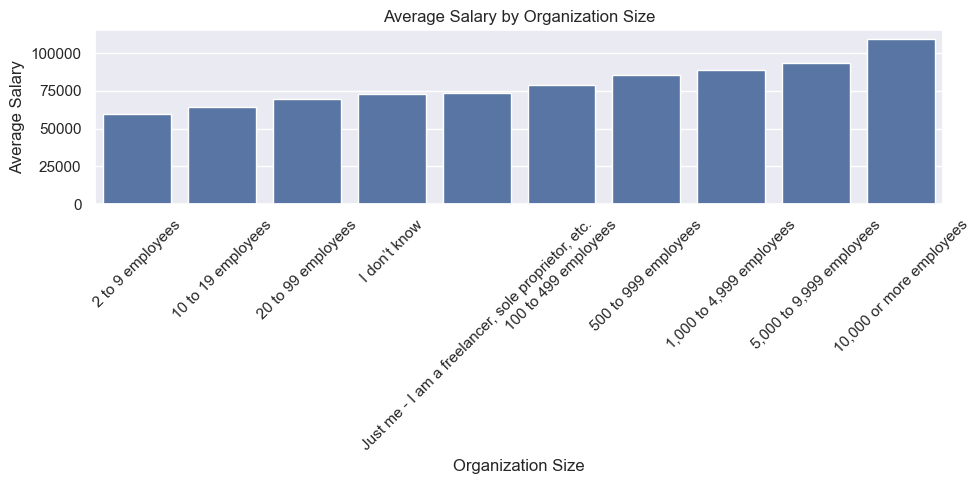

In [23]:
#Average salary by size of organization
plt.figure(figsize=(10, 5))
avg_salary_by_size = df_model.groupby('OrgSize')['ConvertedCompYearly'].mean().sort_values()
sns.barplot(x=avg_salary_by_size.index, y=avg_salary_by_size.values)
plt.title('Average Salary by Organization Size')
plt.xlabel('Organization Size')  
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


I created a bar chart to show average salary based off of organization size

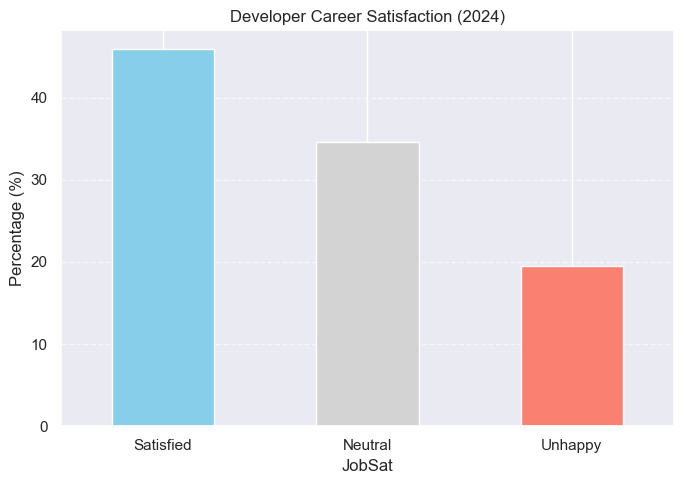

In [25]:

# Categorize satisfaction by either satisfied, neutral, or unhappy
def categorize_satisfaction(x):
    if x in [8.0, 9.0, 10.0]:
        return 'Satisfied'
    elif x in [7.0, 6.0]:
        return 'Neutral'
    elif x in [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]:
        return 'Unhappy'
    else:
        return 'No Response'

if 'JobSat' in df_model.columns:
    # Apply categorization
    job_sat_category = df_model['JobSat'].apply(categorize_satisfaction)

    # Count percentages
    job_sat_counts = job_sat_category.value_counts(normalize=True) * 100
    job_sat_counts = job_sat_counts[['Satisfied', 'Neutral', 'Unhappy']]  

    # Plot
    plt.figure(figsize=(7,5))
    job_sat_counts.plot(kind='bar', color=['skyblue', 'lightgray', 'salmon'])
    plt.title('Developer Career Satisfaction (2024)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'JobSat' not found in df_model.")



This graph is based off of approximately 13,800 respondents who answered the JobSat question on the survey.

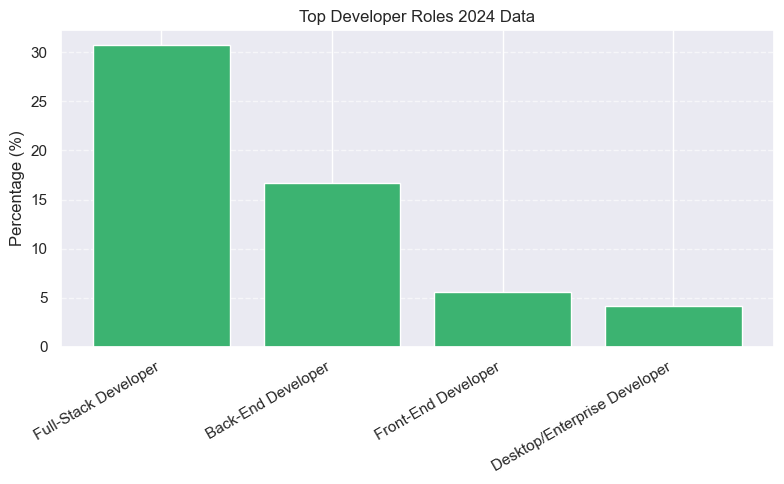

In [27]:
#create a bar chart showing the 4 developer roles and their %

roles = [
    'Full-Stack Developer', 
    'Back-End Developer', 
    'Front-End Developer', 
    'Desktop/Enterprise Developer'
]
role_percentages = [30.7, 16.7, 5.6, 4.2]

# Create the bar chart
plt.figure(figsize=(8,5))
plt.bar(roles, role_percentages, color='mediumseagreen')
plt.ylabel('Percentage (%)')
plt.title('Top Developer Roles 2024 Data')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



These are the top developer roles based off of Stack overflow's 2024 survey

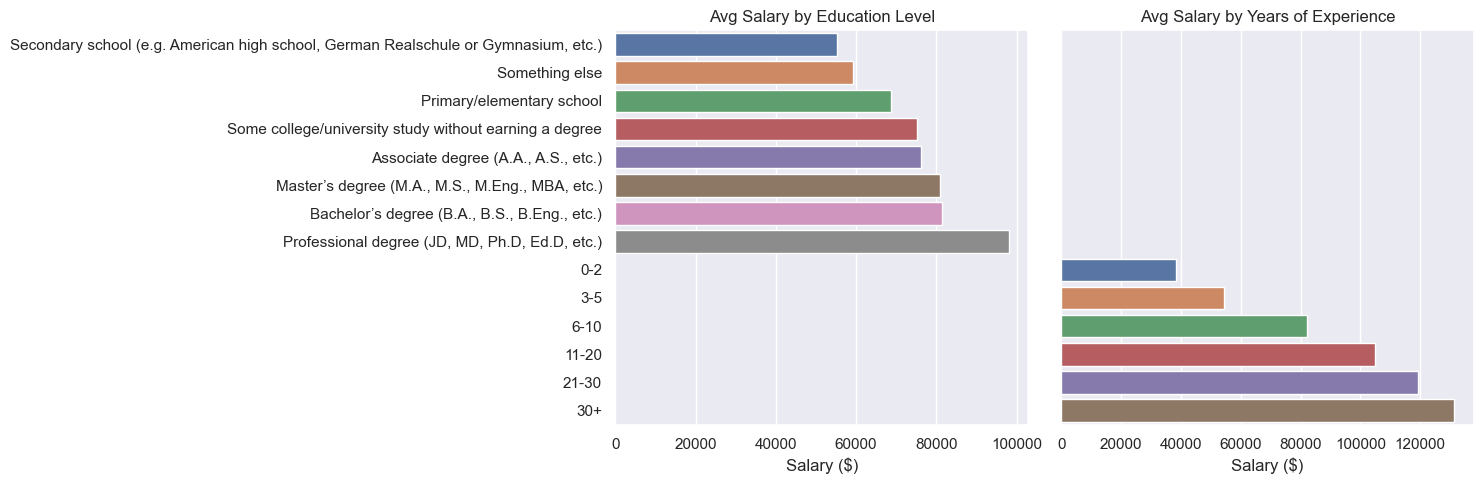

In [46]:
# Make sure YearsCodePro is numeric
df_model['YearsCodePro'] = pd.to_numeric(df_model['YearsCodePro'], errors='coerce')

# Make experience groups
bins = [0, 2, 5, 10, 20, 30, 50]
labels = ['0-2', '3-5', '6-10', '11-20', '21-30', '30+']
df_model['ExperienceGroup'] = pd.cut(df_model['YearsCodePro'], bins=bins, labels=labels)

# Group/calculate average salary
avg_salary_by_edu = df_model.groupby('EdLevel', observed=True)['ConvertedCompYearly'].mean().sort_values()
avg_salary_by_exp = df_model.groupby('ExperienceGroup', observed=True)['ConvertedCompYearly'].mean()

# Plot side-by-side bar charts
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Education plot
sns.barplot(y=avg_salary_by_edu.index, x=avg_salary_by_edu.values, ax=axs[0], hue=avg_salary_by_edu.index, legend=False)
axs[0].set_title('Avg Salary by Education Level')
axs[0].set_xlabel('Salary ($)')
axs[0].set_ylabel('')

# Experience plot
sns.barplot(y=avg_salary_by_exp.index, x=avg_salary_by_exp.values, ax=axs[1], hue=avg_salary_by_exp.index, legend=False)
axs[1].set_title('Avg Salary by Years of Experience')
axs[1].set_xlabel('Salary ($)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


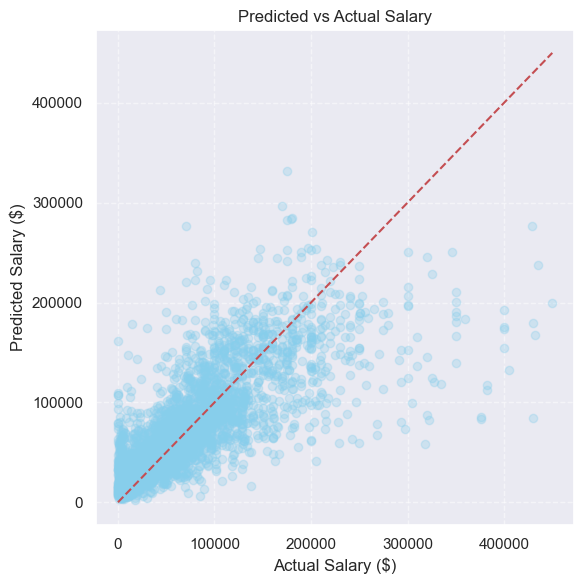

In [64]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal prediction line
plt.xlabel('Actual Salary ($)')
plt.ylabel('Predicted Salary ($)')
plt.title('Predicted vs Actual Salary')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Conclusion (Deployment)
After digging through the 2024 Stack Overflow Developer Survey, we found that things like professional coding experience, education level, and whether someone works remotely all seem to play a role in how much a developer gets paid.

But ,and it's a big but, the model didn’t knock it out of the park. The R2 score was on the low side, which tells us there's still a lot going on behind the scenes that we’re not capturing. Salary isn't just about job titles and years of experience. It’s also about negotiation, location, company size, industry trends, and a bunch of other stuff that’s not always in the dataset.

Still, this was a solid start. We built a working model, cleaned the data, and uncovered some patterns that made sense. If I had more time (and a richer dataset), I'd look into adding more variables. Things like company rating, skill-specific experience, or even soft skills if they were available.

So while the model won't be replacing a recruiter anytime soon, it does give a glimpse into how data can help guide salary expectations. 
